# Using the Algorithms Checker

In this notebook, you will learn how to ...
* ... use IQM Garnet's algorithm checker to check your algorithm ahead of running it on actual hardware.

Using the algorithm checker allows you to save on actual quantum computing time and be best prepared ahead of our execution window. The quantum algorithm checker assists you in identifying errors, syntax issues, or basic problems in your algorithm prior to its submission to IQM Garnet. Instead of a real QPU, it uses mocked software instruments; therefore, it doesn't yield any sensible results. However, it can be used to quickly check that your algorithm compiles and does not have any syntactical errors. In order to use the quantum algorithm checker, you need to specify the server URL of the mock in your algorithm code.

There are only two slight changes in the code you need to apply. We will use the GHZ example for IQM Garnet that you can also find on IQM Academy.

### Installing the necessary packages
In order to get started, make sure you have the appropriate packages installed:

In [ ]:
%%capture
!pip install qiskit-iqm
!pip install networkx
!pip install rustworkx
!pip install matplotlib
!pip install pylatexenc

In order to access the IQM Garnet Algorithms Checker through IQM Resonance, you will need to create an API Token. Copy the token, execute the cell, and paste the token to store it as an environment variable (or follow the guidelines for your system to create an environment variable).

In [2]:
import os
os.environ["IQM_TOKEN"] = input()

## Connecting to IQM Garnet

Let's first check that our connection is working.

We do this by authenticating ourselves to IQM Resonance. Note, that in order to use the algorithm checker, we have added a `:mock`to the url of IQM Garnet.

In [6]:
from iqm.qiskit_iqm import IQMProvider


provider=IQMProvider(url="https://cocos.resonance.meetiqm.com/garnet:mock")
backend = provider.get_backend()

Then we can access the IQM Garnet Mock backend and plot its connectivity graph to check that everything is working properly.

Matplotlib is building the font cache; this may take a moment.


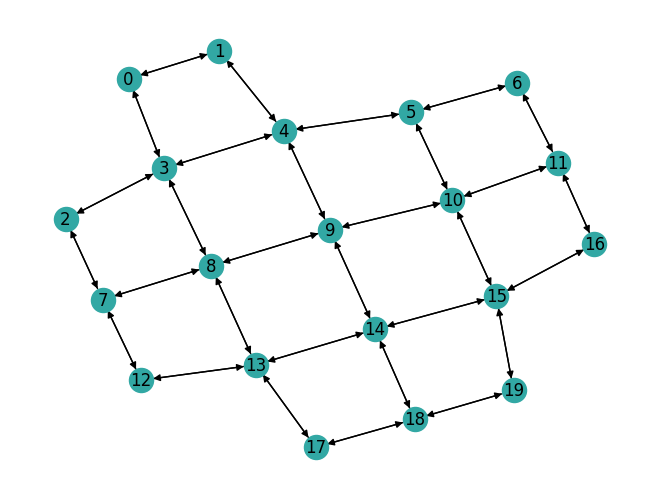

In [7]:
from rustworkx.visualization import mpl_draw
from rustworkx import spring_layout

mpl_draw(backend.coupling_map.graph, arrows=True, with_labels=True, node_color='#32a8a4', pos=spring_layout(backend.coupling_map.graph, num_iter=200))

## Creating the GHZ state using a simulator

The GHZ (Greenberger-Horne-Zeilinger) state is a maximally entangled quantum state that involves three or more qubits. It is an equal superposition of all qubits being in state 0 and all qubits being in state 1. We will use 10 qubits of the 20, we have available on IQM Garnet, this can be represented as:

$$\frac{1}{2}(∣00000000000⟩+ ∣11111111111⟩)$$

If we want to create a GHZ state for a simulator without considering connectivity constraints given by actual quantum computing hardware, we can just do the folllowing:

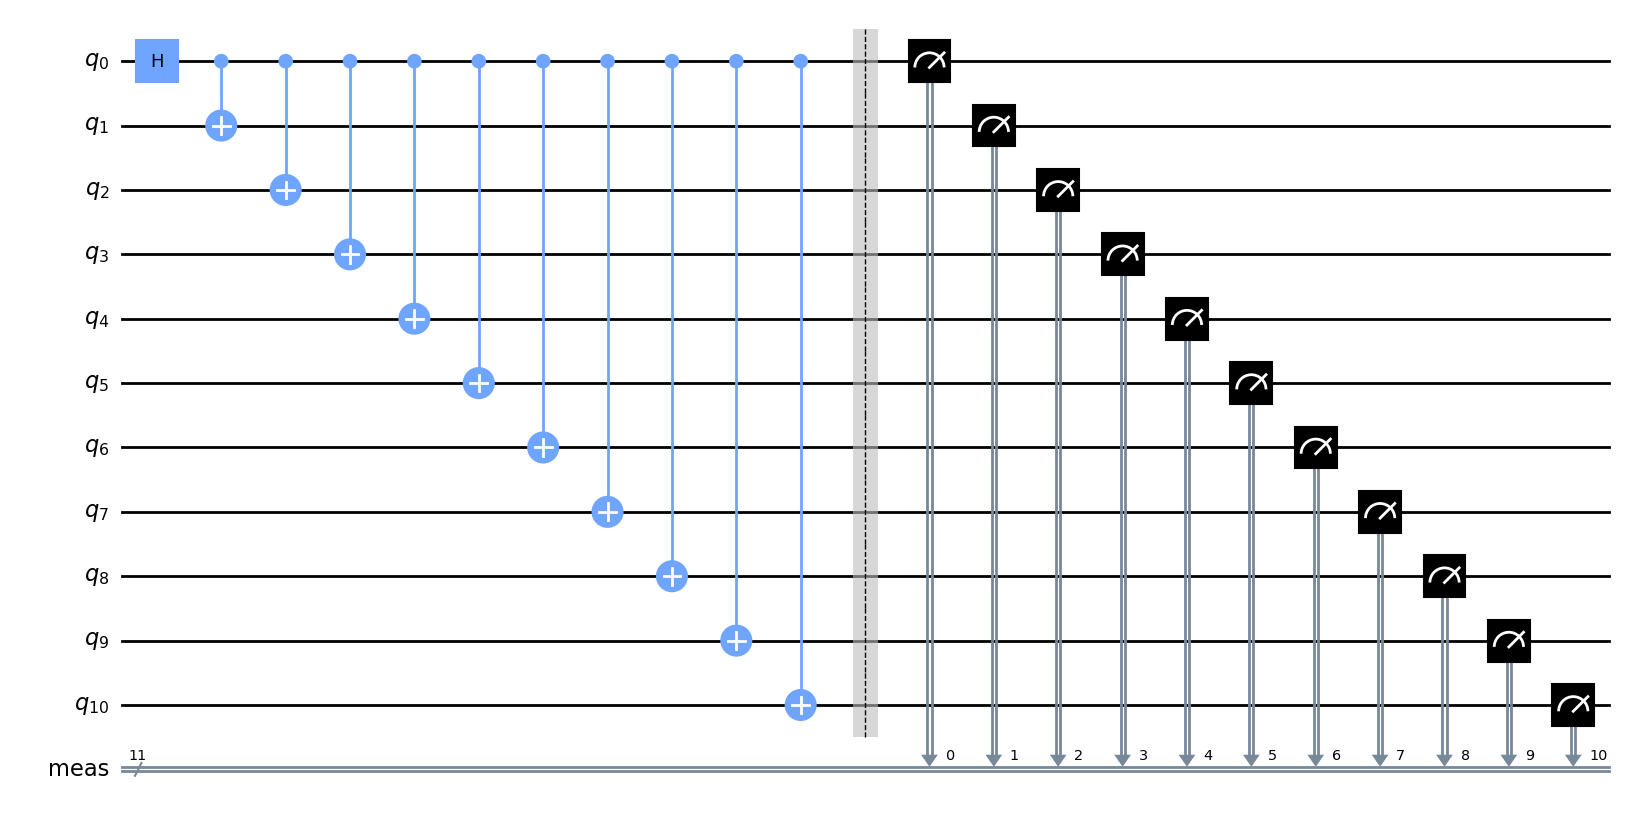

In [8]:
from qiskit import QuantumCircuit

num_qb = 11
qc = QuantumCircuit(num_qb)

qc.h(0)
for qb in range(1, num_qb):
    qc.cx(0, qb)

qc.measure_all()
qc.draw("mpl",  style="clifford")

## Creating the GHZ state with IQM Garnet

When adapting GHZ state generation to the square lattice topology, as seen in IQM Garnet, we can tune our circuit to

In order to create a GHZ state, we follow the steps below:

<ol>
<li> First, we initiate the process by <b>creating a superposition</b> using a Hadamard gate <span style="    display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">H</span> on a qubit.
</li>
<li>  Then, we <b>apply <span style="display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">CNOT</span> gates from one qubit to three other qubits to utilize the connectivity of a square grid</b>.
</li>
<li> Finally, we perform <b>measurements on all qubits. 
</li>
</ol>

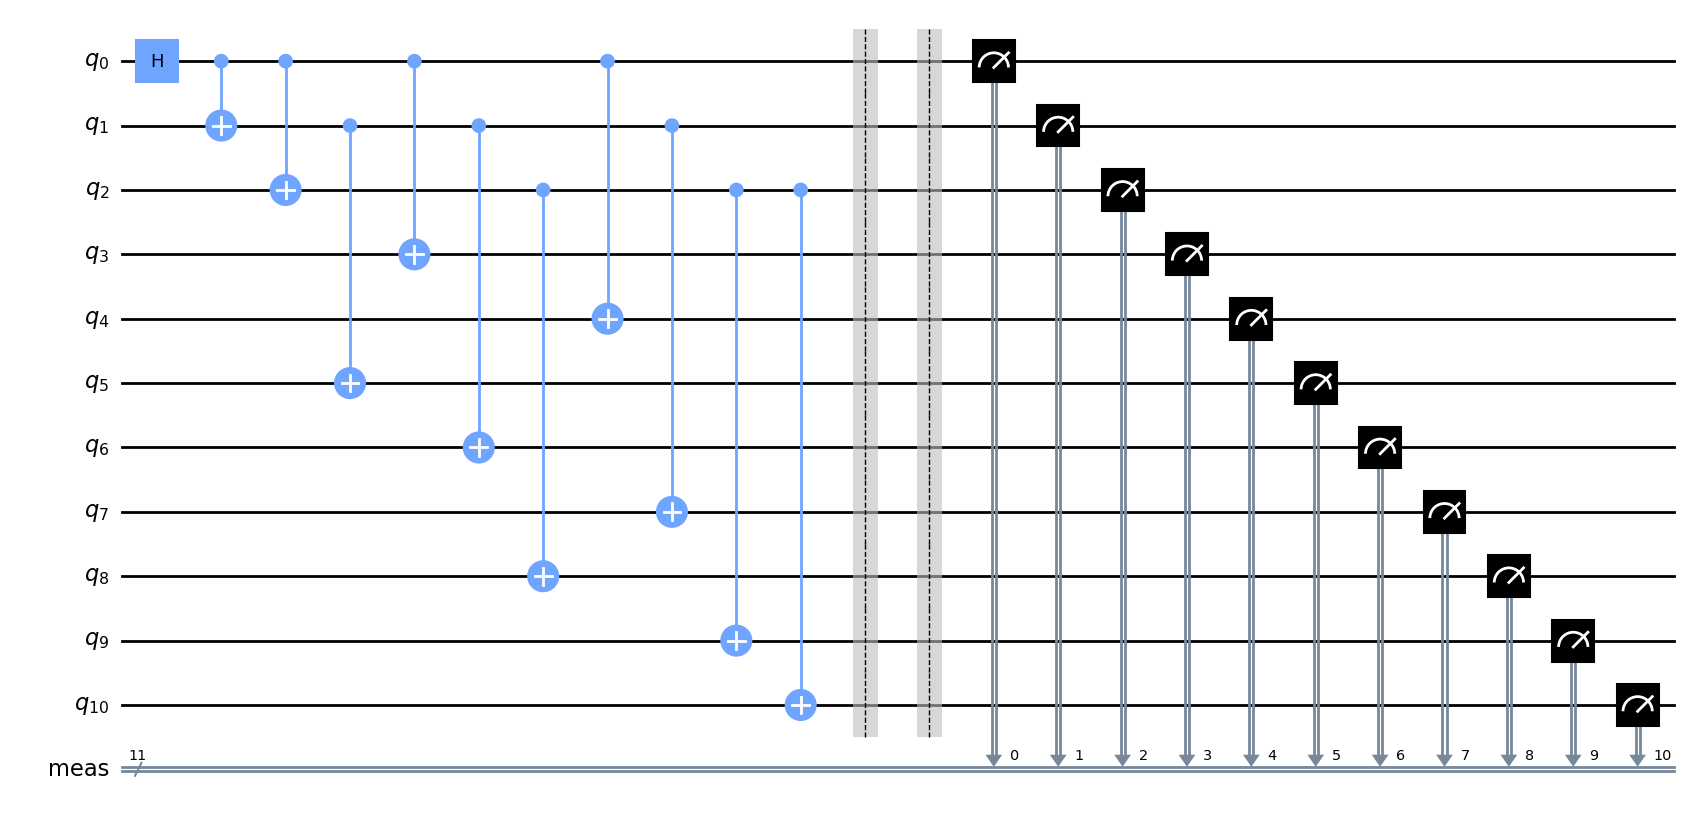

In [9]:
from qiskit import execute
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

# Create Quantum Registers and Quantum Circuit
qc = QuantumCircuit(num_qb)
qc.h(0)
qc.cx(0, 1)
qc.cx(0, 2)
qc.cx(0, 3)
qc.cx(0, 4)
qc.cx(1, 5)
qc.cx(1, 6)
qc.cx(1, 7)
qc.cx(2, 8)
qc.cx(2, 9)
qc.cx(2, 10)

qc.barrier()
qc.measure_all()
qc.draw("mpl", style="clifford")


<div style="background-color: white; margin: 20px 0px; padding: 20px; border-left: 3px solid rgb(222, 199, 84);">
With the circuit prepared, we can now send it to our quantum computer mock environment to see if our code is working. The execute function will carry out several transpilation steps, including decomposing the <span style="    display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">CNOT</span> gate into native gates.
</div>

Please note that the algorithm checker is currently limited to accepting up to 200 circuits with 1024 shots. While you can increase the number of shots (or circuits) when running against a real backend, for the algorithms checker, you need to reduce the numbers temporarily to smaller numbers.

Job Status: job has successfully run


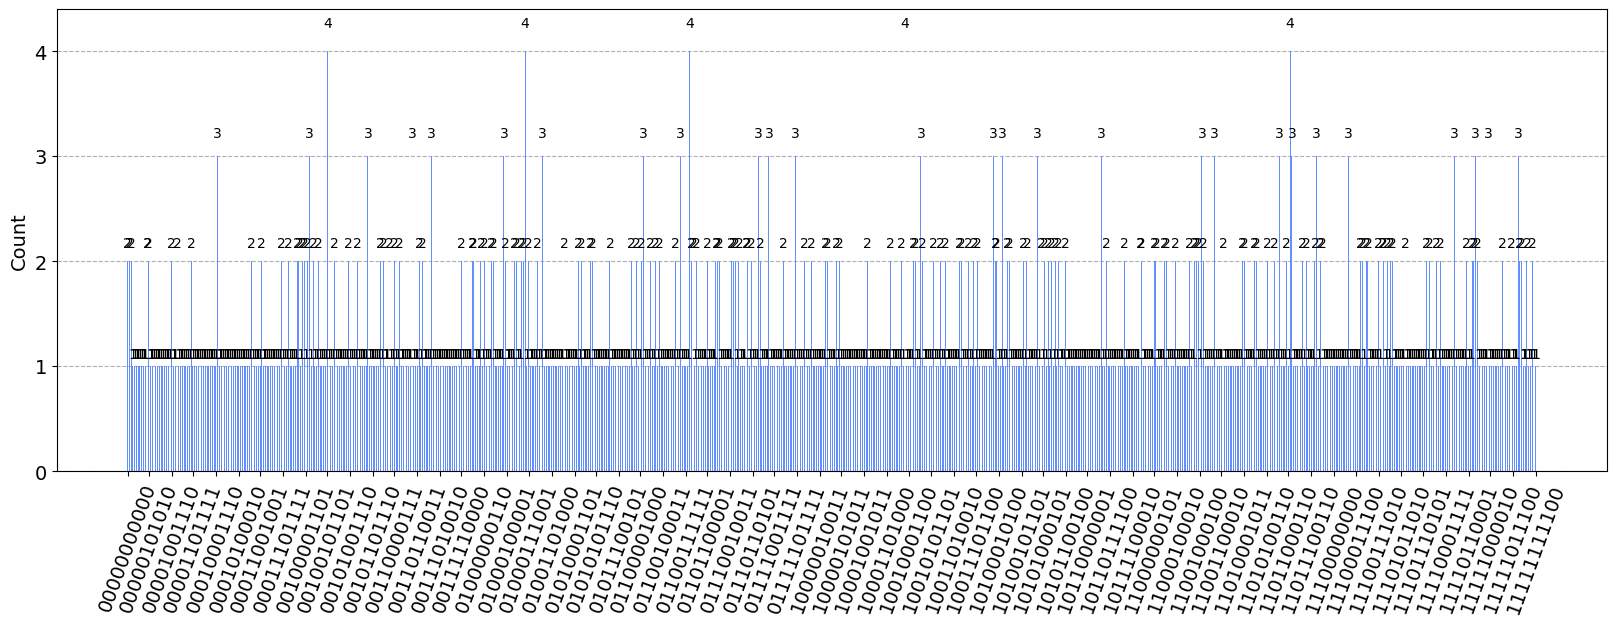

In [12]:
job = execute(qc, backend, shots=1024) # do not use more than 1024 qubits for the algorithms checker

job_monitor(job)

res=job.result()
counts=res.get_counts()

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(20, 6))
plot_histogram(counts, ax=ax)

desired_ticks = 2**6   ### decreasing the total number of tick labels to have a clean figure
x_ticks = np.linspace(0, len(counts)-1, desired_ticks, dtype=int)
ax.set_xticks(x_ticks)

plt.show()

The result looks nothing like a GHZ state. However, this is intended with the algorithms checker and we can now be certain that we can successfully execute our code on the actual IQM Garnet device. 

Check out [this notebook](https://www.iqmacademy.com/notebookViewer/?path=/notebooks/iqm/garnet/GarnetSimpleGHZ.ipynb) to see how you can run your algorithm on an the actual IQM Garnet.

In [ ]:

# Copyright 2024 IQM Quantum Computers (Stefan Seegerer)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.